In [3]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

from pandas.plotting import scatter_matrix

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

import tensorflow as tf

In [4]:
# read in 2018 songs
songs_df = pd.read_csv('data/songs_10000.csv')
songs_df.head()

,Unnamed: 0,Artist,Track Name,Track ID,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
0,0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,90,0.55600,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,1,Lil Baby,Drip Too Hard (Lil Baby & Gunna),78QR3Wp35dqAhFEc2qAGjE,86,0.08520,0.897,145543,0.662,0.000000,1,0.5340,-6.903,0,0.2920,112.511,4,0.389
2,2,Travis Scott,SICKO MODE,2xLMifQCjDGFmkHkpNLD9h,89,0.00513,0.834,312820,0.730,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,0.446
3,3,Juice WRLD,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,88,0.34900,0.511,239836,0.566,0.000000,6,0.3400,-7.230,0,0.2000,83.903,4,0.218
4,4,YNW Melly,Murder On My Mind,7eBqSVxrzQZtK2mmgRG6lC,86,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740


In [5]:
# drop additional index column
songs_df = songs_df.drop(columns = 'Unnamed: 0')

# calculate summary statistics
display(songs_df.describe())

# print out variable types
print(songs_df.dtypes)

,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,58.874600,0.303989,0.634328,200119.502900,0.573902,0.120668,5.307600,0.176829,-8.25150,0.612700,0.120497,119.849287,3.907800,0.440162
std,7.808775,0.307698,0.172954,58370.598685,0.223470,0.287823,3.614732,0.136660,5.49679,0.487158,0.119886,30.873220,0.433495,0.234605
min,46.000000,0.000002,0.000000,31200.000000,0.000020,0.000000,0.000000,0.019600,-44.56900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,0.041775,0.529000,169272.000000,0.438000,0.000000,2.000000,0.099000,-9.35150,0.000000,0.040300,94.973750,4.000000,0.253000
50%,57.000000,0.183000,0.657000,198643.000000,0.593000,0.000002,5.000000,0.120000,-6.79250,1.000000,0.064200,119.986000,4.000000,0.424500
75%,63.000000,0.512000,0.761000,228000.000000,0.739000,0.002010,8.000000,0.205000,-5.10200,1.000000,0.161000,141.987000,4.000000,0.611250
max,90.000000,0.996000,0.985000,688742.000000,0.998000,1.000000,11.000000,0.979000,0.17500,1.000000,0.966000,220.099000,5.000000,0.981000


Artist               object
Track Name           object
Track ID             object
Popularity            int64
Acousticness        float64
Danceability        float64
Duration_ms           int64
Energy              float64
Instrumentalness    float64
Key                   int64
Liveness            float64
Loudness            float64
Mode                  int64
Speechiness         float64
Tempo               float64
Time Signature        int64
Valence             float64
dtype: object


In [ ]:
# matrix of pairwise scatterplots
scatter_matrix(songs_df, alpha = 0.8, figsize = (30, 20), diagonal = 'kde')

In [6]:
# create new binary response variable 'tophit'
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)

In [56]:
# prepare for modeling
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

In [39]:
# fit cross-validated single decision tree
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        # get training set scores
        train_scores[i] = accuracy_score(y_train, y_pred)
        # get cross-validation scores
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

In [9]:
# report best tree depth from cross-validation
best_depth = sorted(cvmeans, key = cvmeans.get, reverse = True)[0]
print('Best depth:', best_depth)

# refit on best tree depth, then report classification accuracies
best_model = DecisionTreeClassifier(max_depth = best_depth)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_train_pred)
print('Classification accuracy on training set:', best_cv_tree_train_score)

y_test_pred = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_test_pred)
print('Classification accuracy on test set:', best_cv_tree_test_score)

Best depth: 3
Classification accuracy on training set: 0.645
Classification accuracy on test set: 0.6395


In [57]:
cat_cols = ['Key', 'Time Signature']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [59]:
X_test

,Key_0,Key_1,Key_2,Key_3,Key_4,Key_5,Key_6,Key_7,Key_8,Key_9,Key_10,Key_11,Time Signature_0,Time Signature_1,Time Signature_3,Time Signature_4,Time Signature_5,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence
5760,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.002126,0.299492,0.256368,0.716427,0.000002,0.231333,0.850080,1.0,0.073395,0.394990,0.246939
5683,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.832329,0.492386,0.225507,0.619231,0.000004,0.155933,0.813003,1.0,0.065942,0.591706,0.465306
7125,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.210842,0.576650,0.267664,0.302591,0.000000,0.086815,0.821384,1.0,0.029089,0.378979,0.218367
8092,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.527107,0.390863,0.346355,0.362713,0.000120,0.076553,0.794274,1.0,0.036128,0.538967,0.188776
5228,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.262047,0.748223,0.348043,0.724443,0.000097,0.066918,0.864429,1.0,0.051760,0.524237,0.666327
4715,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000569,0.616244,0.250428,0.744484,0.000010,0.188397,0.884700,1.0,0.038923,0.581293,0.767347
645,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.051303,0.982741,0.351473,0.590172,0.000000,0.054456,0.821585,1.0,0.263975,0.590611,0.273469
4600,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.052307,0.627411,0.200290,0.561113,0.938000,0.195727,0.712118,0.0,0.025466,0.454586,0.121429
6146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.795180,0.356345,0.378925,0.290567,0.000000,0.304639,0.809695,1.0,0.030642,0.653706,0.343878
7682,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.000010,0.237563,0.253184,0.928856,0.000039,0.097288,0.864920,0.0,0.448240,0.595200,0.283673


In [61]:
# binary: ANN
# specify network layers
binary_ann = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),  
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 5600 samples, validate on 2400 samples
Epoch 1/1000
5600/5600 [==============================] - 0s 77us/sample - loss: 0.6560 - accuracy: 0.6371 - val_loss: 0.6458 - val_accuracy: 0.6454
Epoch 2/1000
5600/5600 [==============================] - 0s 43us/sample - loss: 0.6463 - accuracy: 0.6416 - val_loss: 0.6395 - val_accuracy: 0.6454
Epoch 3/1000
5600/5600 [==============================] - 0s 41us/sample - loss: 0.6422 - accuracy: 0.6416 - val_loss: 0.6369 - val_accuracy: 0.6454
Epoch 4/1000
5600/5600 [==============================] - 0s 42us/sample - loss: 0.6412 - accuracy: 0.6416 - val_loss: 0.6440 - val_accuracy: 0.6454
Epoch 5/1000
5600/5600 [==============================] - 0s 40us/sample - loss: 0.6368 - accuracy: 0.6416 - val_loss: 0.6380 - val_accuracy: 0.6429
Epoch 6/1000
5600/5600 [==============================] - 0s 38us/sample - loss: 0.6313 - accuracy: 0.6439 - val_loss: 0.6367 - val_accuracy: 0.6438
Epoch 7/1000
5600/5600 [==============================] - 

5600/5600 [==============================] - 0s 33us/sample - loss: 0.1442 - accuracy: 0.9436 - val_loss: 2.1405 - val_accuracy: 0.5858
Epoch 109/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.1408 - accuracy: 0.9459 - val_loss: 2.1783 - val_accuracy: 0.5754
Epoch 110/1000
5600/5600 [==============================] - 0s 38us/sample - loss: 0.1333 - accuracy: 0.9475 - val_loss: 2.1810 - val_accuracy: 0.5967
Epoch 111/1000
5600/5600 [==============================] - 0s 37us/sample - loss: 0.1374 - accuracy: 0.9463 - val_loss: 2.2914 - val_accuracy: 0.5775
Epoch 112/1000
5600/5600 [==============================] - 0s 43us/sample - loss: 0.1848 - accuracy: 0.9214 - val_loss: 2.1859 - val_accuracy: 0.5650
Epoch 113/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.1849 - accuracy: 0.9259 - val_loss: 2.1745 - val_accuracy: 0.5858
Epoch 114/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.1824 - accuracy: 0.9236 

5600/5600 [==============================] - 0s 32us/sample - loss: 0.0758 - accuracy: 0.9741 - val_loss: 3.0430 - val_accuracy: 0.5738
Epoch 217/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0830 - accuracy: 0.9711 - val_loss: 3.0178 - val_accuracy: 0.5654
Epoch 218/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.1106 - accuracy: 0.9613 - val_loss: 3.0103 - val_accuracy: 0.5779
Epoch 219/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.1064 - accuracy: 0.9607 - val_loss: 3.1044 - val_accuracy: 0.5750
Epoch 220/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.1019 - accuracy: 0.9671 - val_loss: 3.0335 - val_accuracy: 0.5717
Epoch 221/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.1104 - accuracy: 0.9625 - val_loss: 2.9757 - val_accuracy: 0.5679
Epoch 222/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0993 - accuracy: 0.9648 

5600/5600 [==============================] - 0s 32us/sample - loss: 0.0268 - accuracy: 0.9904 - val_loss: 3.2368 - val_accuracy: 0.5788
Epoch 325/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0250 - accuracy: 0.9909 - val_loss: 3.3072 - val_accuracy: 0.5829
Epoch 326/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0295 - accuracy: 0.9902 - val_loss: 3.2444 - val_accuracy: 0.5875
Epoch 327/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0289 - accuracy: 0.9902 - val_loss: 3.3325 - val_accuracy: 0.5733
Epoch 328/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0303 - accuracy: 0.9898 - val_loss: 3.3086 - val_accuracy: 0.5775
Epoch 329/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0282 - accuracy: 0.9900 - val_loss: 3.2989 - val_accuracy: 0.5888
Epoch 330/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0254 - accuracy: 0.9912 

5600/5600 [==============================] - 0s 32us/sample - loss: 0.0251 - accuracy: 0.9909 - val_loss: 3.4856 - val_accuracy: 0.5667
Epoch 433/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0286 - accuracy: 0.9900 - val_loss: 3.4837 - val_accuracy: 0.5775
Epoch 434/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0351 - accuracy: 0.9859 - val_loss: 3.4861 - val_accuracy: 0.5679
Epoch 435/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0452 - accuracy: 0.9834 - val_loss: 3.4223 - val_accuracy: 0.5813
Epoch 436/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0607 - accuracy: 0.9791 - val_loss: 3.3482 - val_accuracy: 0.5729
Epoch 437/1000
5600/5600 [==============================] - 0s 37us/sample - loss: 0.0652 - accuracy: 0.9750 - val_loss: 3.3953 - val_accuracy: 0.5742
Epoch 438/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0910 - accuracy: 0.9671 

5600/5600 [==============================] - 0s 33us/sample - loss: 0.0225 - accuracy: 0.9905 - val_loss: 3.4530 - val_accuracy: 0.5713
Epoch 541/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0216 - accuracy: 0.9909 - val_loss: 3.4542 - val_accuracy: 0.5721
Epoch 542/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0177 - accuracy: 0.9921 - val_loss: 3.5215 - val_accuracy: 0.5758
Epoch 543/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0202 - accuracy: 0.9909 - val_loss: 3.4380 - val_accuracy: 0.5796
Epoch 544/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0214 - accuracy: 0.9902 - val_loss: 3.4778 - val_accuracy: 0.5763
Epoch 545/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0173 - accuracy: 0.9927 - val_loss: 3.4311 - val_accuracy: 0.5821
Epoch 546/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0197 - accuracy: 0.9912 

5600/5600 [==============================] - 0s 33us/sample - loss: 0.0173 - accuracy: 0.9927 - val_loss: 3.3683 - val_accuracy: 0.5813
Epoch 649/1000
5600/5600 [==============================] - 0s 35us/sample - loss: 0.0177 - accuracy: 0.9921 - val_loss: 3.3730 - val_accuracy: 0.5858
Epoch 650/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0154 - accuracy: 0.9927 - val_loss: 3.3886 - val_accuracy: 0.5808
Epoch 651/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0162 - accuracy: 0.9916 - val_loss: 3.4245 - val_accuracy: 0.5733
Epoch 652/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0141 - accuracy: 0.9923 - val_loss: 3.4465 - val_accuracy: 0.5783
Epoch 653/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0160 - accuracy: 0.9921 - val_loss: 3.3897 - val_accuracy: 0.5925
Epoch 654/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0214 - accuracy: 0.9907 

5600/5600 [==============================] - 0s 33us/sample - loss: 0.0135 - accuracy: 0.9934 - val_loss: 3.4310 - val_accuracy: 0.5817
Epoch 757/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0159 - accuracy: 0.9921 - val_loss: 3.3654 - val_accuracy: 0.5850
Epoch 758/1000
5600/5600 [==============================] - 0s 35us/sample - loss: 0.0154 - accuracy: 0.9916 - val_loss: 3.4180 - val_accuracy: 0.5792
Epoch 759/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0161 - accuracy: 0.9920 - val_loss: 3.4067 - val_accuracy: 0.5913
Epoch 760/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0135 - accuracy: 0.9918 - val_loss: 3.4170 - val_accuracy: 0.5904
Epoch 761/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0137 - accuracy: 0.9920 - val_loss: 3.4082 - val_accuracy: 0.5863
Epoch 762/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0161 - accuracy: 0.9923 

5600/5600 [==============================] - 0s 33us/sample - loss: 0.0852 - accuracy: 0.9677 - val_loss: 3.0978 - val_accuracy: 0.5833
Epoch 865/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0820 - accuracy: 0.9702 - val_loss: 2.9624 - val_accuracy: 0.5929
Epoch 866/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0463 - accuracy: 0.9827 - val_loss: 3.1571 - val_accuracy: 0.5896
Epoch 867/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0485 - accuracy: 0.9825 - val_loss: 3.2092 - val_accuracy: 0.5729
Epoch 868/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0322 - accuracy: 0.9866 - val_loss: 3.2218 - val_accuracy: 0.5846
Epoch 869/1000
5600/5600 [==============================] - 0s 32us/sample - loss: 0.0209 - accuracy: 0.9920 - val_loss: 3.2867 - val_accuracy: 0.5921
Epoch 870/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.0200 - accuracy: 0.9907 

5600/5600 [==============================] - 0s 38us/sample - loss: 0.0692 - accuracy: 0.9720 - val_loss: 3.0830 - val_accuracy: 0.5842
Epoch 973/1000
5600/5600 [==============================] - 0s 36us/sample - loss: 0.0286 - accuracy: 0.9879 - val_loss: 3.1467 - val_accuracy: 0.5925
Epoch 974/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.0167 - accuracy: 0.9918 - val_loss: 3.2350 - val_accuracy: 0.5796
Epoch 975/1000
5600/5600 [==============================] - 0s 42us/sample - loss: 0.0139 - accuracy: 0.9930 - val_loss: 3.2581 - val_accuracy: 0.5867
Epoch 976/1000
5600/5600 [==============================] - 0s 38us/sample - loss: 0.0119 - accuracy: 0.9930 - val_loss: 3.3109 - val_accuracy: 0.5863
Epoch 977/1000
5600/5600 [==============================] - 0s 39us/sample - loss: 0.0111 - accuracy: 0.9936 - val_loss: 3.3331 - val_accuracy: 0.5950
Epoch 978/1000
5600/5600 [==============================] - 0s 38us/sample - loss: 0.0129 - accuracy: 0.9923 

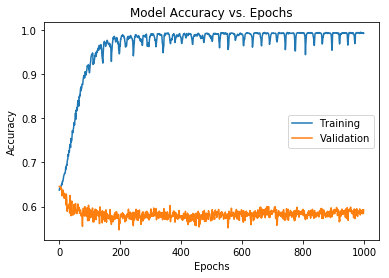

In [62]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [63]:
# specify network layers
binary_ann = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, )),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann.fit(X_train, y_train, epochs = 1000, batch_size = 128, validation_split = 0.3)

Train on 5600 samples, validate on 2400 samples
Epoch 1/1000
5600/5600 [==============================] - 0s 63us/sample - loss: 0.6613 - accuracy: 0.6254 - val_loss: 0.6458 - val_accuracy: 0.6454
Epoch 2/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.6473 - accuracy: 0.6416 - val_loss: 0.6412 - val_accuracy: 0.6454
Epoch 3/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.6435 - accuracy: 0.6416 - val_loss: 0.6401 - val_accuracy: 0.6454
Epoch 4/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.6410 - accuracy: 0.6416 - val_loss: 0.6382 - val_accuracy: 0.6454
Epoch 5/1000
5600/5600 [==============================] - 0s 34us/sample - loss: 0.6381 - accuracy: 0.6423 - val_loss: 0.6382 - val_accuracy: 0.6446
Epoch 6/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.6359 - accuracy: 0.6425 - val_loss: 0.6375 - val_accuracy: 0.6454
Epoch 7/1000
5600/5600 [==============================] - 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.4882 - accuracy: 0.7500 - val_loss: 0.7775 - val_accuracy: 0.6171
Epoch 109/1000
5600/5600 [==============================] - 0s 68us/sample - loss: 0.4849 - accuracy: 0.7520 - val_loss: 0.7816 - val_accuracy: 0.5979
Epoch 110/1000
5600/5600 [==============================] - 0s 66us/sample - loss: 0.4874 - accuracy: 0.7482 - val_loss: 0.7740 - val_accuracy: 0.6071
Epoch 111/1000
5600/5600 [==============================] - 1s 102us/sample - loss: 0.4860 - accuracy: 0.7543 - val_loss: 0.7889 - val_accuracy: 0.6083
Epoch 112/1000
5600/5600 [==============================] - 0s 46us/sample - loss: 0.4825 - accuracy: 0.7500 - val_loss: 0.7857 - val_accuracy: 0.6112
Epoch 113/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.4820 - accuracy: 0.7554 - val_loss: 0.7847 - val_accuracy: 0.5942
Epoch 114/1000
5600/5600 [==============================] - 0s 31us/sample - loss: 0.4865 - accuracy: 0.7505

5600/5600 [==============================] - 0s 39us/sample - loss: 0.3926 - accuracy: 0.8129 - val_loss: 0.9723 - val_accuracy: 0.5846
Epoch 217/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.3955 - accuracy: 0.8086 - val_loss: 0.9746 - val_accuracy: 0.5800
Epoch 218/1000
5600/5600 [==============================] - 0s 24us/sample - loss: 0.3918 - accuracy: 0.8164 - val_loss: 0.9843 - val_accuracy: 0.5829
Epoch 219/1000
5600/5600 [==============================] - 0s 23us/sample - loss: 0.3927 - accuracy: 0.8104 - val_loss: 1.0023 - val_accuracy: 0.5842
Epoch 220/1000
5600/5600 [==============================] - 0s 23us/sample - loss: 0.3921 - accuracy: 0.8145 - val_loss: 1.0005 - val_accuracy: 0.5833
Epoch 221/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.3912 - accuracy: 0.8150 - val_loss: 1.0054 - val_accuracy: 0.5813
Epoch 222/1000
5600/5600 [==============================] - 0s 27us/sample - loss: 0.3929 - accuracy: 0.8093 

5600/5600 [==============================] - 0s 33us/sample - loss: 0.3286 - accuracy: 0.8489 - val_loss: 1.1864 - val_accuracy: 0.5792
Epoch 325/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.3317 - accuracy: 0.8461 - val_loss: 1.2141 - val_accuracy: 0.5729
Epoch 326/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.3338 - accuracy: 0.8414 - val_loss: 1.1800 - val_accuracy: 0.5754
Epoch 327/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.3265 - accuracy: 0.8486 - val_loss: 1.1839 - val_accuracy: 0.5996
Epoch 328/1000
5600/5600 [==============================] - 0s 40us/sample - loss: 0.3269 - accuracy: 0.8448 - val_loss: 1.1930 - val_accuracy: 0.5938
Epoch 329/1000
5600/5600 [==============================] - 0s 40us/sample - loss: 0.3330 - accuracy: 0.8457 - val_loss: 1.1766 - val_accuracy: 0.5679
Epoch 330/1000
5600/5600 [==============================] - 0s 33us/sample - loss: 0.3247 - accuracy: 0.8520 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.2747 - accuracy: 0.8786 - val_loss: 1.3634 - val_accuracy: 0.5871
Epoch 433/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.2775 - accuracy: 0.8802 - val_loss: 1.3562 - val_accuracy: 0.5675
Epoch 434/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.2766 - accuracy: 0.8779 - val_loss: 1.3780 - val_accuracy: 0.5758
Epoch 435/1000
5600/5600 [==============================] - 0s 23us/sample - loss: 0.2729 - accuracy: 0.8813 - val_loss: 1.3567 - val_accuracy: 0.5854
Epoch 436/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.2786 - accuracy: 0.8745 - val_loss: 1.3612 - val_accuracy: 0.5792
Epoch 437/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2715 - accuracy: 0.8791 - val_loss: 1.3798 - val_accuracy: 0.5696
Epoch 438/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.2775 - accuracy: 0.8789 

5600/5600 [==============================] - 0s 26us/sample - loss: 0.2309 - accuracy: 0.9059 - val_loss: 1.5491 - val_accuracy: 0.5804
Epoch 541/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2357 - accuracy: 0.9025 - val_loss: 1.5785 - val_accuracy: 0.5808
Epoch 542/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.2401 - accuracy: 0.8995 - val_loss: 1.5585 - val_accuracy: 0.5638
Epoch 543/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.2313 - accuracy: 0.9032 - val_loss: 1.5814 - val_accuracy: 0.5658
Epoch 544/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2335 - accuracy: 0.9034 - val_loss: 1.5707 - val_accuracy: 0.5708
Epoch 545/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.2361 - accuracy: 0.8971 - val_loss: 1.5449 - val_accuracy: 0.5863
Epoch 546/1000
5600/5600 [==============================] - 0s 23us/sample - loss: 0.2312 - accuracy: 0.9023 

5600/5600 [==============================] - 0s 25us/sample - loss: 0.1957 - accuracy: 0.9218 - val_loss: 1.7003 - val_accuracy: 0.5708
Epoch 649/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.1996 - accuracy: 0.9221 - val_loss: 1.7181 - val_accuracy: 0.5696
Epoch 650/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1927 - accuracy: 0.9211 - val_loss: 1.7149 - val_accuracy: 0.5721
Epoch 651/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.1950 - accuracy: 0.9236 - val_loss: 1.7257 - val_accuracy: 0.5642
Epoch 652/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1970 - accuracy: 0.9216 - val_loss: 1.7294 - val_accuracy: 0.5621
Epoch 653/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1987 - accuracy: 0.9230 - val_loss: 1.6851 - val_accuracy: 0.5758
Epoch 654/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.2035 - accuracy: 0.9191 

5600/5600 [==============================] - 0s 26us/sample - loss: 0.1757 - accuracy: 0.9357 - val_loss: 1.9044 - val_accuracy: 0.5642
Epoch 757/1000
5600/5600 [==============================] - 0s 23us/sample - loss: 0.1768 - accuracy: 0.9325 - val_loss: 1.8760 - val_accuracy: 0.5783
Epoch 758/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1733 - accuracy: 0.9359 - val_loss: 1.9024 - val_accuracy: 0.5658
Epoch 759/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1693 - accuracy: 0.9362 - val_loss: 1.8882 - val_accuracy: 0.5608
Epoch 760/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.1698 - accuracy: 0.9366 - val_loss: 1.9287 - val_accuracy: 0.5708
Epoch 761/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1655 - accuracy: 0.9355 - val_loss: 1.8792 - val_accuracy: 0.5771
Epoch 762/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.1653 - accuracy: 0.9405 

5600/5600 [==============================] - 0s 27us/sample - loss: 0.1433 - accuracy: 0.9493 - val_loss: 2.0583 - val_accuracy: 0.5754
Epoch 865/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1473 - accuracy: 0.9448 - val_loss: 2.0387 - val_accuracy: 0.5746
Epoch 866/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1465 - accuracy: 0.9464 - val_loss: 2.0359 - val_accuracy: 0.5667
Epoch 867/1000
5600/5600 [==============================] - 0s 24us/sample - loss: 0.1397 - accuracy: 0.9511 - val_loss: 2.0595 - val_accuracy: 0.5650
Epoch 868/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1472 - accuracy: 0.9459 - val_loss: 2.0717 - val_accuracy: 0.5646
Epoch 869/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1442 - accuracy: 0.9482 - val_loss: 2.0476 - val_accuracy: 0.5746
Epoch 870/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1476 - accuracy: 0.9473 

5600/5600 [==============================] - 0s 26us/sample - loss: 0.1196 - accuracy: 0.9605 - val_loss: 2.2308 - val_accuracy: 0.5604
Epoch 973/1000
5600/5600 [==============================] - 0s 25us/sample - loss: 0.1246 - accuracy: 0.9552 - val_loss: 2.1970 - val_accuracy: 0.5638
Epoch 974/1000
5600/5600 [==============================] - 0s 26us/sample - loss: 0.1266 - accuracy: 0.9570 - val_loss: 2.2244 - val_accuracy: 0.5696
Epoch 975/1000
5600/5600 [==============================] - 0s 28us/sample - loss: 0.1247 - accuracy: 0.9548 - val_loss: 2.2227 - val_accuracy: 0.5633
Epoch 976/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1232 - accuracy: 0.9598 - val_loss: 2.2201 - val_accuracy: 0.5704
Epoch 977/1000
5600/5600 [==============================] - 0s 29us/sample - loss: 0.1232 - accuracy: 0.9571 - val_loss: 2.2146 - val_accuracy: 0.5692
Epoch 978/1000
5600/5600 [==============================] - 0s 30us/sample - loss: 0.1245 - accuracy: 0.9579 

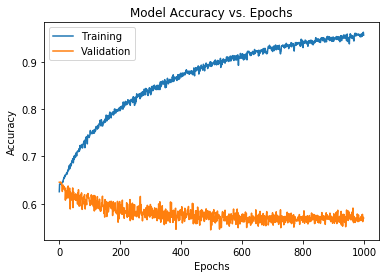

In [64]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [74]:
# specify network layers
binary_ann = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, )),
    tf.keras.layers.Dense(100, activation = 'relu', 
                       kernel_regularizer = tf.keras.regularizers.l2(l = 0.1)),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# compile and fit network
binary_ann.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
history = binary_ann.fit(X_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.3)

Train on 5600 samples, validate on 2400 samples
Epoch 1/100
5600/5600 [==============================] - 0s 70us/sample - loss: 3.8890 - accuracy: 0.6266 - val_loss: 2.9066 - val_accuracy: 0.6454
Epoch 2/100
5600/5600 [==============================] - 0s 30us/sample - loss: 2.2940 - accuracy: 0.6416 - val_loss: 1.7667 - val_accuracy: 0.6454
Epoch 3/100
5600/5600 [==============================] - 0s 32us/sample - loss: 1.4486 - accuracy: 0.6416 - val_loss: 1.1760 - val_accuracy: 0.6454
Epoch 4/100
5600/5600 [==============================] - 0s 31us/sample - loss: 1.0190 - accuracy: 0.6416 - val_loss: 0.8836 - val_accuracy: 0.6454
Epoch 5/100
5600/5600 [==============================] - 0s 30us/sample - loss: 0.8125 - accuracy: 0.6416 - val_loss: 0.7500 - val_accuracy: 0.6454
Epoch 6/100
5600/5600 [==============================] - 0s 31us/sample - loss: 0.7165 - accuracy: 0.6416 - val_loss: 0.6907 - val_accuracy: 0.6454
Epoch 7/100
5600/5600 [==============================] - 0s 32us

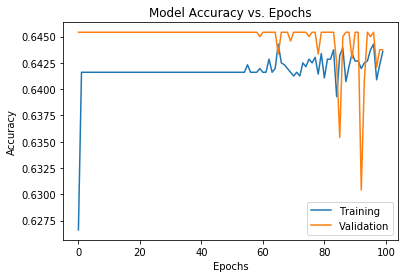

In [77]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

In [106]:
songs_df = pd.read_csv('data/songs_10000.csv')

# drop additional index column
songs_df = songs_df.drop(columns = 'Unnamed: 0')

songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean.Popularity, test_size = 0.2, 
                                                    random_state = 100)

In [107]:
cat_cols = ['Key', 'Time Signature']
X_train_num = X_train.drop(cat_cols, axis = 1)
X_test_num = X_test.drop(cat_cols, axis = 1)
num_features = X_train_num.columns.tolist()
num_index_train = X_train.index.tolist()
num_index_test = X_test.index.tolist()

X_train_dum = pd.get_dummies(X_train[cat_cols], columns = cat_cols)
X_test_dum = pd.get_dummies(X_test[cat_cols], columns = cat_cols)

scaler = MinMaxScaler().fit(X_train_num)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), index = num_index_train, columns = num_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = num_index_test, columns = num_features)

X_train = pd.concat([X_train_dum, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_dum, X_test_scaled], axis = 1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [108]:
# quantitative: ANN
# specify network layers
quant_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation = 'sigmoid', input_shape = (28, )),
    tf.keras.layers.Dense(10, activation = 'linear')
])

# compile and fit network
quant_ann.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['accuracy']) 
history = quant_ann.fit(X_train, y_train, epochs = 1000, batch_size = 32, validation_split = 0.3)

Train on 5600 samples, validate on 2400 samples
Epoch 1/1000
5600/5600 [==============================] - 1s 91us/sample - loss: 58.6572 - accuracy: 0.0000e+00 - val_loss: 58.0132 - val_accuracy: 0.0000e+00
Epoch 2/1000
5600/5600 [==============================] - 0s 67us/sample - loss: 57.6399 - accuracy: 0.0000e+00 - val_loss: 56.8782 - val_accuracy: 0.0000e+00
Epoch 3/1000
5600/5600 [==============================] - 0s 72us/sample - loss: 56.4721 - accuracy: 0.0000e+00 - val_loss: 55.6473 - val_accuracy: 0.0000e+00
Epoch 4/1000
5600/5600 [==============================] - 0s 69us/sample - loss: 55.1845 - accuracy: 0.0000e+00 - val_loss: 54.3559 - val_accuracy: 0.0000e+00
Epoch 5/1000
5600/5600 [==============================] - 0s 70us/sample - loss: 53.9383 - accuracy: 0.0000e+00 - val_loss: 53.1504 - val_accuracy: 0.0000e+00
Epoch 6/1000
5600/5600 [==============================] - 1s 97us/sample - loss: 52.7599 - accuracy: 0.0000e+00 - val_loss: 51.9943 - val_accuracy: 0.0000e+0

5600/5600 [==============================] - 0s 81us/sample - loss: 7.1413 - accuracy: 0.0000e+00 - val_loss: 6.8252 - val_accuracy: 0.0000e+00
Epoch 53/1000
5600/5600 [==============================] - 0s 76us/sample - loss: 6.9046 - accuracy: 0.0000e+00 - val_loss: 6.6039 - val_accuracy: 0.0000e+00
Epoch 54/1000
5600/5600 [==============================] - 0s 83us/sample - loss: 6.7222 - accuracy: 0.0000e+00 - val_loss: 6.4406 - val_accuracy: 0.0000e+00
Epoch 55/1000
5600/5600 [==============================] - 0s 78us/sample - loss: 6.5785 - accuracy: 0.0000e+00 - val_loss: 6.3083 - val_accuracy: 0.0000e+00
Epoch 56/1000
5600/5600 [==============================] - 0s 57us/sample - loss: 6.4739 - accuracy: 0.0000e+00 - val_loss: 6.2213 - val_accuracy: 0.0000e+00
Epoch 57/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 6.3945 - accuracy: 0.0000e+00 - val_loss: 6.1509 - val_accuracy: 0.0000e+00
Epoch 58/1000
5600/5600 [==============================] - 0s 56us

5600/5600 [==============================] - 0s 56us/sample - loss: 6.0543 - accuracy: 0.0411 - val_loss: 5.8799 - val_accuracy: 0.0475
Epoch 160/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 6.0537 - accuracy: 0.0341 - val_loss: 5.8825 - val_accuracy: 0.0208
Epoch 161/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 6.0521 - accuracy: 0.0271 - val_loss: 5.8790 - val_accuracy: 0.0396
Epoch 162/1000
5600/5600 [==============================] - 0s 68us/sample - loss: 6.0518 - accuracy: 0.0464 - val_loss: 5.8797 - val_accuracy: 0.0625
Epoch 163/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 6.0516 - accuracy: 0.0520 - val_loss: 5.8793 - val_accuracy: 0.0546
Epoch 164/1000
5600/5600 [==============================] - 0s 58us/sample - loss: 6.0508 - accuracy: 0.0477 - val_loss: 5.8794 - val_accuracy: 0.0467
Epoch 165/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 6.0498 - accuracy: 0.0336 

5600/5600 [==============================] - 0s 60us/sample - loss: 5.9974 - accuracy: 0.1416 - val_loss: 5.8731 - val_accuracy: 0.1371
Epoch 268/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9963 - accuracy: 0.1202 - val_loss: 5.8722 - val_accuracy: 0.1279
Epoch 269/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9965 - accuracy: 0.1164 - val_loss: 5.8718 - val_accuracy: 0.1412
Epoch 270/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9959 - accuracy: 0.1489 - val_loss: 5.8730 - val_accuracy: 0.1733
Epoch 271/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9970 - accuracy: 0.1502 - val_loss: 5.8717 - val_accuracy: 0.1688
Epoch 272/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9958 - accuracy: 0.1527 - val_loss: 5.8722 - val_accuracy: 0.1771
Epoch 273/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9947 - accuracy: 0.1557 

5600/5600 [==============================] - 0s 70us/sample - loss: 5.9708 - accuracy: 0.1014 - val_loss: 5.8804 - val_accuracy: 0.1433
Epoch 376/1000
5600/5600 [==============================] - 0s 63us/sample - loss: 5.9716 - accuracy: 0.1357 - val_loss: 5.8809 - val_accuracy: 0.1625
Epoch 377/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9706 - accuracy: 0.1596 - val_loss: 5.8805 - val_accuracy: 0.1633
Epoch 378/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9714 - accuracy: 0.1520 - val_loss: 5.8805 - val_accuracy: 0.1596
Epoch 379/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9709 - accuracy: 0.1525 - val_loss: 5.8807 - val_accuracy: 0.1529
Epoch 380/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9702 - accuracy: 0.1068 - val_loss: 5.8812 - val_accuracy: 0.1067
Epoch 381/1000
5600/5600 [==============================] - 0s 56us/sample - loss: 5.9707 - accuracy: 0.0977 

5600/5600 [==============================] - 0s 50us/sample - loss: 5.9511 - accuracy: 0.2354 - val_loss: 5.8892 - val_accuracy: 0.1787
Epoch 484/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9513 - accuracy: 0.1655 - val_loss: 5.8884 - val_accuracy: 0.1579
Epoch 485/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9502 - accuracy: 0.2043 - val_loss: 5.8888 - val_accuracy: 0.1621
Epoch 486/1000
5600/5600 [==============================] - 0s 49us/sample - loss: 5.9503 - accuracy: 0.1680 - val_loss: 5.8893 - val_accuracy: 0.1821
Epoch 487/1000
5600/5600 [==============================] - 0s 51us/sample - loss: 5.9507 - accuracy: 0.2075 - val_loss: 5.8886 - val_accuracy: 0.1917
Epoch 488/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9506 - accuracy: 0.2387 - val_loss: 5.8892 - val_accuracy: 0.1729
Epoch 489/1000
5600/5600 [==============================] - 0s 49us/sample - loss: 5.9486 - accuracy: 0.1805 

5600/5600 [==============================] - 0s 50us/sample - loss: 5.9379 - accuracy: 0.3614 - val_loss: 5.8890 - val_accuracy: 0.2854
Epoch 592/1000
5600/5600 [==============================] - 0s 51us/sample - loss: 5.9371 - accuracy: 0.3250 - val_loss: 5.8891 - val_accuracy: 0.1950
Epoch 593/1000
5600/5600 [==============================] - 0s 54us/sample - loss: 5.9361 - accuracy: 0.2288 - val_loss: 5.8885 - val_accuracy: 0.1867
Epoch 594/1000
5600/5600 [==============================] - 0s 49us/sample - loss: 5.9358 - accuracy: 0.2537 - val_loss: 5.8886 - val_accuracy: 0.2696
Epoch 595/1000
5600/5600 [==============================] - 0s 51us/sample - loss: 5.9361 - accuracy: 0.3123 - val_loss: 5.8900 - val_accuracy: 0.3396
Epoch 596/1000
5600/5600 [==============================] - 0s 49us/sample - loss: 5.9366 - accuracy: 0.3479 - val_loss: 5.8882 - val_accuracy: 0.2433
Epoch 597/1000
5600/5600 [==============================] - 0s 49us/sample - loss: 5.9355 - accuracy: 0.3179 

5600/5600 [==============================] - 0s 50us/sample - loss: 5.9254 - accuracy: 0.2425 - val_loss: 5.8892 - val_accuracy: 0.2212
Epoch 700/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9245 - accuracy: 0.2966 - val_loss: 5.8891 - val_accuracy: 0.3250
Epoch 701/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9248 - accuracy: 0.3055 - val_loss: 5.8874 - val_accuracy: 0.3346
Epoch 702/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9251 - accuracy: 0.3254 - val_loss: 5.8869 - val_accuracy: 0.3308
Epoch 703/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9251 - accuracy: 0.2652 - val_loss: 5.8873 - val_accuracy: 0.2779
Epoch 704/1000
5600/5600 [==============================] - 0s 53us/sample - loss: 5.9242 - accuracy: 0.3020 - val_loss: 5.8877 - val_accuracy: 0.2454
Epoch 705/1000
5600/5600 [==============================] - 0s 54us/sample - loss: 5.9247 - accuracy: 0.2295 

5600/5600 [==============================] - 0s 50us/sample - loss: 5.9118 - accuracy: 0.3293 - val_loss: 5.8917 - val_accuracy: 0.3054
Epoch 808/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9125 - accuracy: 0.3029 - val_loss: 5.8902 - val_accuracy: 0.2512
Epoch 809/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9132 - accuracy: 0.3311 - val_loss: 5.8909 - val_accuracy: 0.3963
Epoch 810/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9128 - accuracy: 0.3079 - val_loss: 5.8913 - val_accuracy: 0.3217
Epoch 811/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9122 - accuracy: 0.3082 - val_loss: 5.8924 - val_accuracy: 0.2733
Epoch 812/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9116 - accuracy: 0.2377 - val_loss: 5.8918 - val_accuracy: 0.2508
Epoch 813/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9127 - accuracy: 0.2773 

5600/5600 [==============================] - 0s 50us/sample - loss: 5.9022 - accuracy: 0.3379 - val_loss: 5.8930 - val_accuracy: 0.2767
Epoch 916/1000
5600/5600 [==============================] - 0s 51us/sample - loss: 5.9019 - accuracy: 0.2905 - val_loss: 5.8944 - val_accuracy: 0.2508
Epoch 917/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9021 - accuracy: 0.1852 - val_loss: 5.8950 - val_accuracy: 0.0846
Epoch 918/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9022 - accuracy: 0.1180 - val_loss: 5.8933 - val_accuracy: 0.1804
Epoch 919/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9031 - accuracy: 0.1918 - val_loss: 5.8952 - val_accuracy: 0.2175
Epoch 920/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9010 - accuracy: 0.1887 - val_loss: 5.8939 - val_accuracy: 0.2096
Epoch 921/1000
5600/5600 [==============================] - 0s 50us/sample - loss: 5.9031 - accuracy: 0.1905 

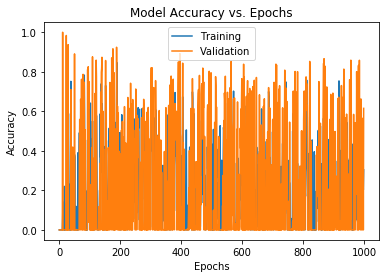

In [104]:
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()